# Keras models to graphviz dot

This require the the [visutil_improve](https://github.com/julienr/keras/tree/visutil_improve) keras branch

In [3]:
import keras
import keras.models as models
from keras.layers.core import Dense, Activation, Merge
from keras.layers.core import Dense, Activation, Flatten, Dropout
from keras.layers.convolutional import Convolution2D, MaxPooling2D
from IPython.display import SVG

import keras.utils.visualize_util as vutil

Couldn't import dot_parser, loading of dot files will not be possible.


# Sequential model with submodels

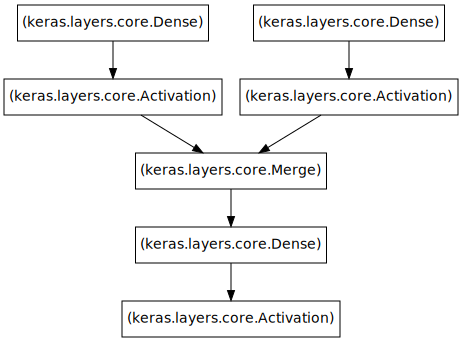

In [4]:
reload(vutil)

left = models.Sequential()
left.add(Dense(50, input_shape=(784,)))
left.add(Activation('relu'))

right = models.Sequential()
right.add(Dense(50, input_shape=(784,)))
right.add(Activation('relu'))

seqm1 = models.Sequential()
seqm1.add(Merge([left, right], mode='sum'))

seqm1.add(Dense(10))
seqm1.add(Activation('softmax'))

SVG(vutil.to_graph(seqm1, recursive=True, show_shape=False).create(prog='dot', format="svg"))

# CNN

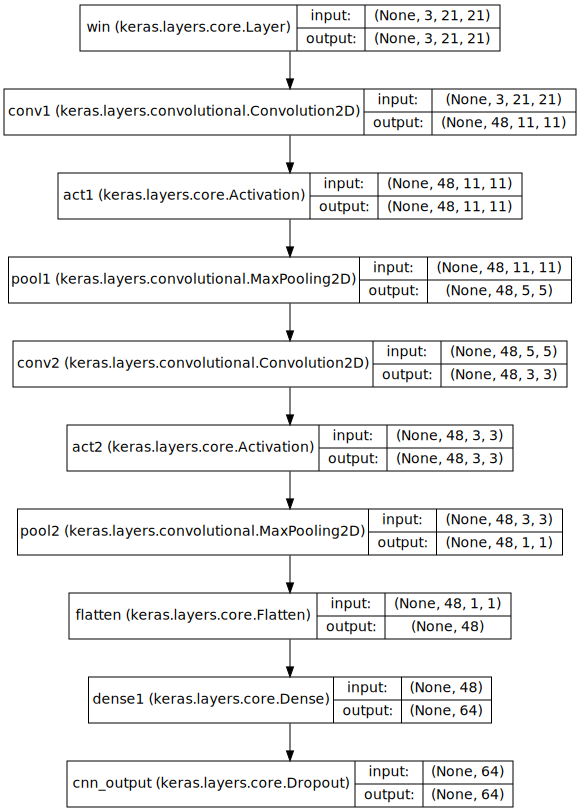

In [5]:
reload(vutil)

activation = 'relu'
cnn = models.Graph()
cnn.add_input(name='win', input_shape=(3, 21, 21))

cnn.add_node(Convolution2D(48, 11, 11, border_mode='valid'), name='conv1', input='win')
cnn.add_node(Activation(activation), name='act1', input='conv1')
cnn.add_node(MaxPooling2D(pool_size=(2,2)), name='pool1', input='act1')
cnn.add_node(Dropout(0.25), name='dropout1', input='pool1')

cnn.add_node(Convolution2D(48, 3, 3, border_mode='valid'), name='conv2', input='pool1')
cnn.add_node(Activation(activation), name='act2', input='conv2')
cnn.add_node(MaxPooling2D(pool_size=(2,2)), name='pool2', input='act2')
cnn.add_node(Dropout(0.25), name='dropout2', input='pool2')

cnn.add_node(Flatten(), name='flatten', input='pool2')
cnn.add_node(Dense(64), name='dense1', input='flatten')
cnn.add_node(Dropout(0.1), name='dropout3', input='dense1')

cnn.add_output(name='cnn_output', input='dropout3')

SVG(vutil.to_graph(cnn, recursive=True, show_shape=True).create(prog='dot', format="svg"))

# Dense

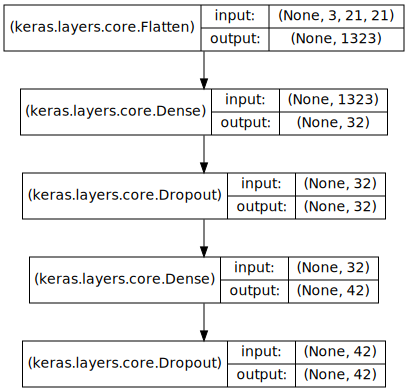

In [6]:
reload(vutil)

nn = models.Sequential()
nn.add(Flatten(input_shape=(3, 21, 21)))
nn.add(Dense(32))
nn.add(Dropout(0.25))
nn.add(Dense(42))
nn.add(Dropout(0.25))

SVG(vutil.to_graph(nn, recursive=True, show_shape=True).create(prog='dot', format="svg"))

# Merge our Graph-based CNN and our Dense NN using a Graph model

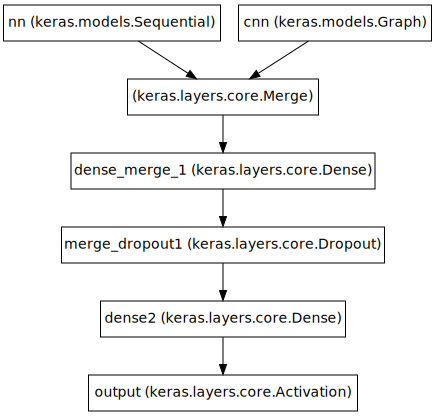

In [7]:
model = models.Graph()
model.add_input(name='windows', input_shape=(3, 21, 21))
model.add_node(nn, name='nn', input='windows')
model.add_node(cnn, name='cnn', input='windows')

model.add_node(Dense(64), name='dense_merge_1', inputs=['nn', 'cnn'], merge_mode='concat')
model.add_node(Dropout(0.1), name='merge_dropout1', input='dense_merge_1')
model.add_node(Dense(10), name='dense2', input='merge_dropout1')
model.add_node(Activation('softmax'), name='softmax', input='dense2')
model.add_output(name='output', input='softmax')

# Non-recursive, no shape = simple plot
SVG(vutil.to_graph(model, recursive=False, show_shape=False).create(prog='dot', format="svg"))

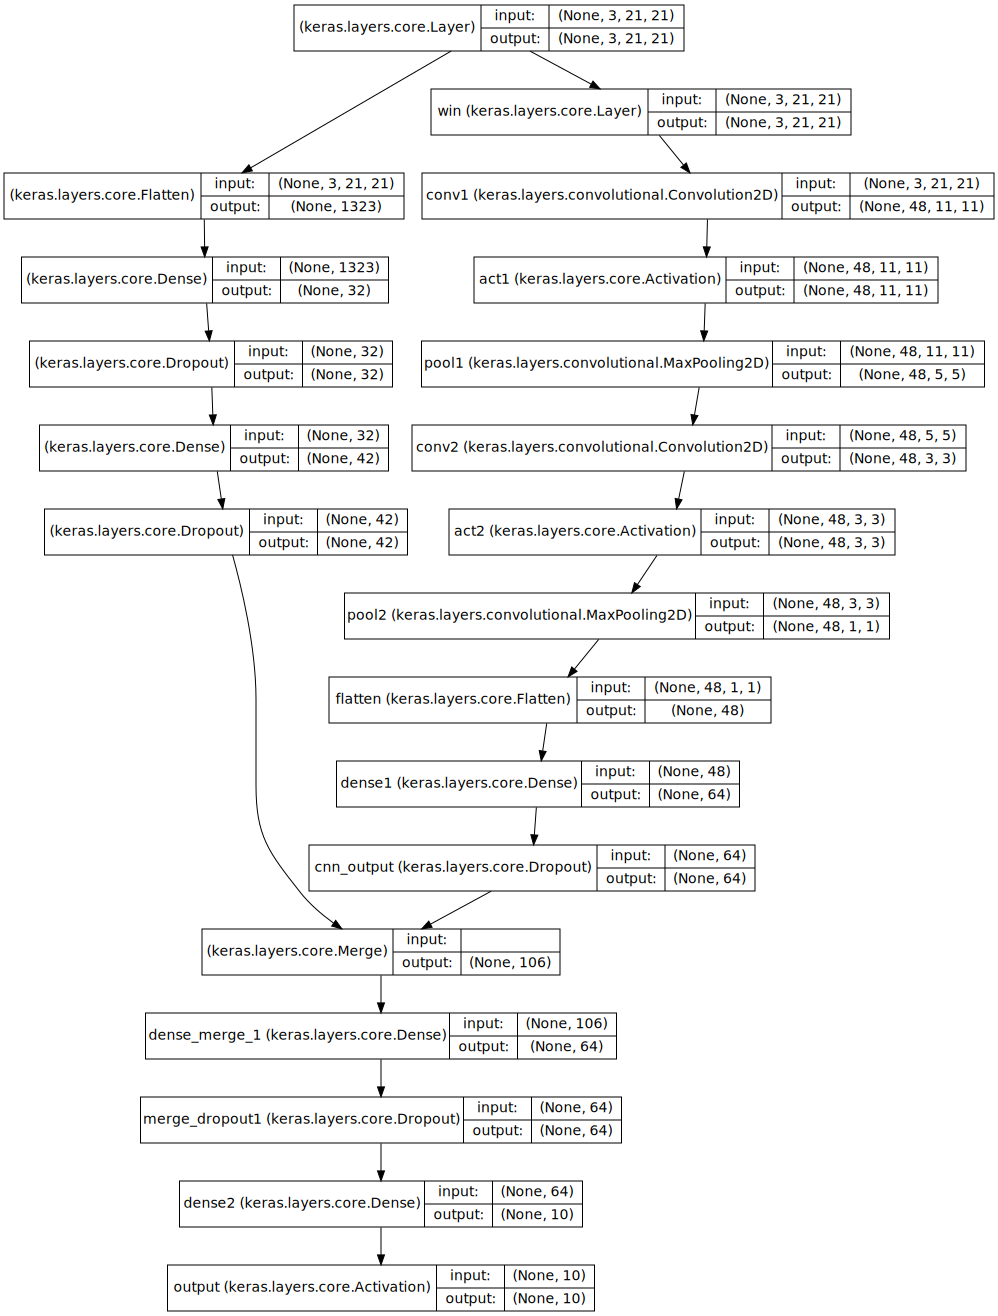

In [8]:
# Recursive + shape in all its glory
SVG(vutil.to_graph(model, recursive=True, show_shape=True).create(prog='dot', format="svg"))

# Convnet + GRU example

In [49]:
from keras.layers.embeddings import Embedding
from keras.layers.recurrent import GRU, LSTM
from keras.layers.core import RepeatVector, TimeDistributedDense

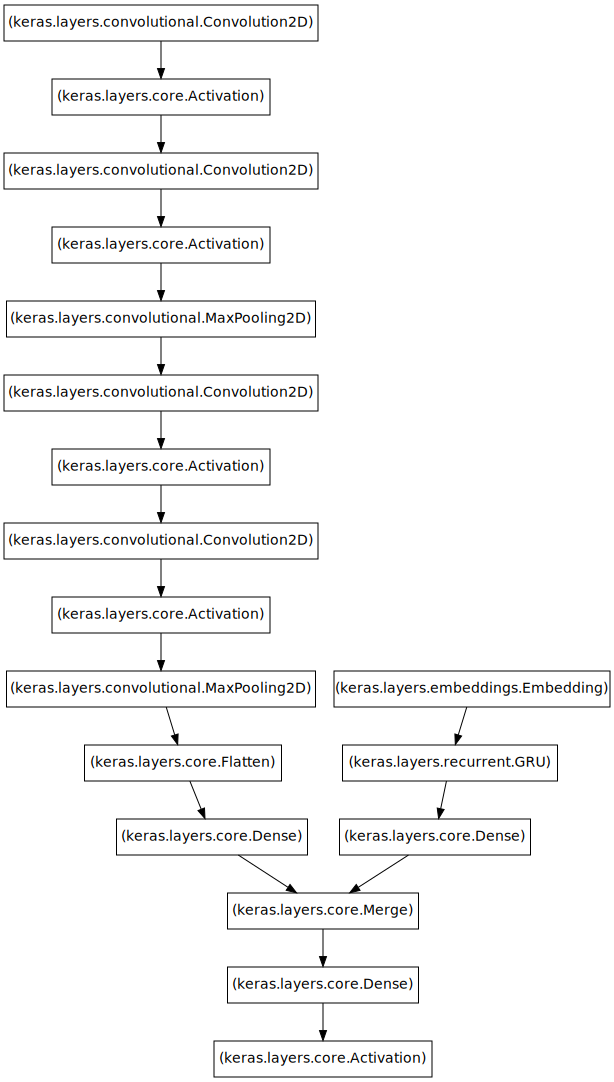

In [64]:
max_caption_len = 16
vocab_size = 10000

# first, let's define an image model that
# will encode pictures into 128-dimensional vectors.
# it should be initialized with pre-trained weights.
image_model = models.Sequential()
image_model.add(Convolution2D(32, 3, 3, border_mode='full', input_shape=(3, 100, 100)))
image_model.add(Activation('relu'))
image_model.add(Convolution2D(32, 3, 3))
image_model.add(Activation('relu'))
image_model.add(MaxPooling2D(pool_size=(2, 2)))

image_model.add(Convolution2D(64, 3, 3, border_mode='full'))
image_model.add(Activation('relu'))
image_model.add(Convolution2D(64, 3, 3))
image_model.add(Activation('relu'))
image_model.add(MaxPooling2D(pool_size=(2, 2)))

image_model.add(Flatten())
image_model.add(Dense(128))

# next, let's define a RNN model that encodes sequences of words
# into sequences of 128-dimensional word vectors.
language_model = models.Sequential()
language_model.add(Embedding(vocab_size, 256, input_length=max_caption_len))
#language_model.add(GRU(128, return_sequences=True))
language_model.add(GRU(128, return_sequences=False))
language_model.add(Dense(128))

# let's repeat the image vector to turn it into a sequence.
#image_model.add(RepeatVector(max_caption_len))

# the output of both models will be tensors of shape (samples, max_caption_len, 128).
# let's concatenate these 2 vector sequences.
model = models.Sequential()
model.add(Merge([image_model, language_model], mode='concat', concat_axis=-1))
# let's encode this vector sequence into a single vector
#model.add(GRU(256, 256, return_sequences=False))
#model.add(GRU(256, return_sequences=False))
# which will be used to compute a probability
# distribution over what the next word in the caption should be!
model.add(Dense(vocab_size))
model.add(Activation('softmax'))

# Recursive + shape in all its glory
SVG(vutil.to_graph(model, recursive=True, show_shape=False).create(prog='dot', format="svg"))